In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00


# Загружаем необходимые зависимости

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import shap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# 1. Выбор набора данных:

In [ ]:
data = pd.read_csv('winequality-red.csv')
X = data.drop('quality', axis=1)
y = data['quality']
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# 2. Построение моделей и оценка значимости признаков

In [ ]:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Mon, 16 Dec 2024   Prob (F-statistic):          1.79e-145
Time:                        11:41:42   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:                    1587   BIC:                             3227.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   21.9652 

In [ ]:
X.head()

,const,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,1.0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,1.0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,1.0,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,1.0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [ ]:
lr = LinearRegression()

selector = RFE(lr, n_features_to_select=5)
selector = selector.fit(X.drop(columns=['const']), y)

selected_features = X.columns[1:][selector.support_]
print("Выбранные признаки:", selected_features)

Выбранные признаки: Index(['volatile acidity', 'chlorides', 'density', 'pH', 'sulphates'], dtype='object')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['const']), y, test_size=0.2, random_state=42)

alphas = [0.01, 0.1, 0.5, 1, 5, 10]
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    print(f"Alpha: {alpha}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print("Количество ненулевых коэффициентов:", np.sum(lasso.coef_ != 0))


Alpha: 0.01, RMSE: 0.645704643470843
Количество ненулевых коэффициентов: 7
Alpha: 0.1, RMSE: 0.7061693586346531
Количество ненулевых коэффициентов: 4
Alpha: 0.5, RMSE: 0.8050004777013742
Количество ненулевых коэффициентов: 2
Alpha: 1, RMSE: 0.8047451268061234
Количество ненулевых коэффициентов: 1
Alpha: 5, RMSE: 0.8095203101463155
Количество ненулевых коэффициентов: 1
Alpha: 10, RMSE: 0.81065409945582
Количество ненулевых коэффициентов: 0


# 3. Визуализация значимости признаков:

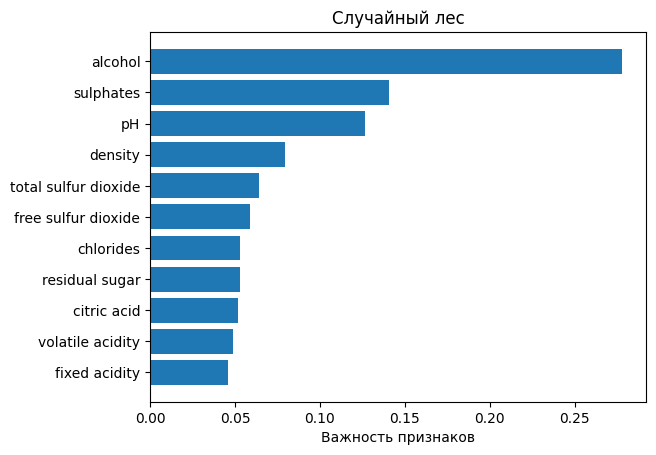

In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X.drop(columns=['const']), y)
feature_importances = rf.feature_importances_
sorted_idx = np.argsort(feature_importances)

plt.barh(X.columns[1:], feature_importances[sorted_idx])
plt.xlabel("Важность признаков")
plt.title("Случайный лес")
plt.show()

 92%|==================  | 1475/1599 [00:13<00:01]       

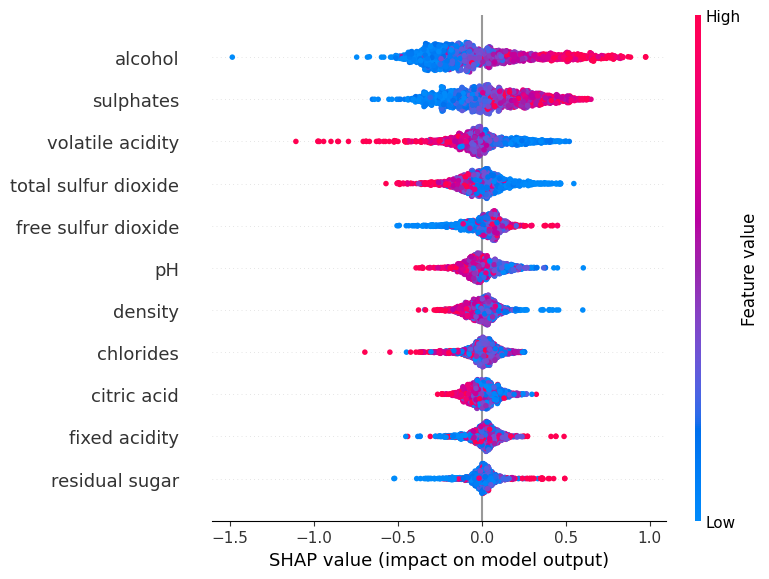

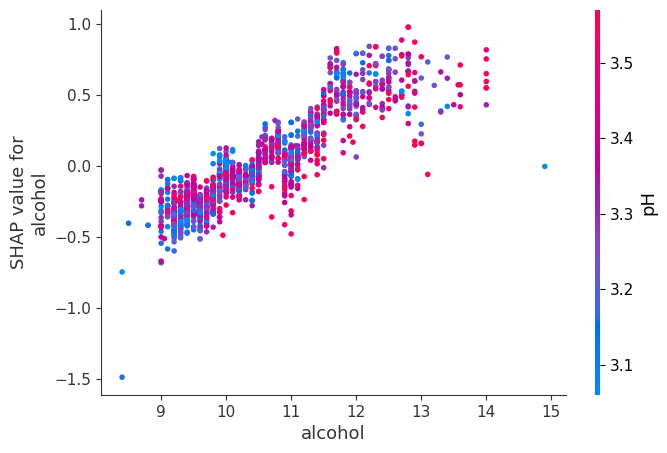

In [ ]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X.drop(columns=['const']), y)

explainer = shap.Explainer(xgb, X.drop(columns=['const']))

shap_values = explainer(X.drop(columns=['const']))
shap.summary_plot(shap_values, X.drop(columns=['const']))
shap_values_array = shap_values.values
shap.dependence_plot("alcohol", shap_values_array, X.drop(columns=['const']))

# 4. Сравнение качества моделей

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R^2:", r2_score(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

X_train_full, X_test_full, y_train, y_test = train_test_split(X.drop(columns=['const']), y, test_size=0.2, random_state=42)

top_features = X.columns[1:][np.argsort(rf.feature_importances_)[-5:]]
X_train_top = X_train_full[top_features]
X_test_top = X_test_full[top_features]

print("На всех признаках:")
evaluate_model(RandomForestRegressor(random_state=42), X_train_full, X_test_full, y_train, y_test)

print("На выбранных признаках:")
evaluate_model(RandomForestRegressor(random_state=42), X_train_top, X_test_top, y_train, y_test)

На всех признаках:
R^2: 0.5390429623873638
RMSE: 0.5488516420673258
На выбранных признаках:
R^2: 0.4937091110148091
RMSE: 0.5752078428707313


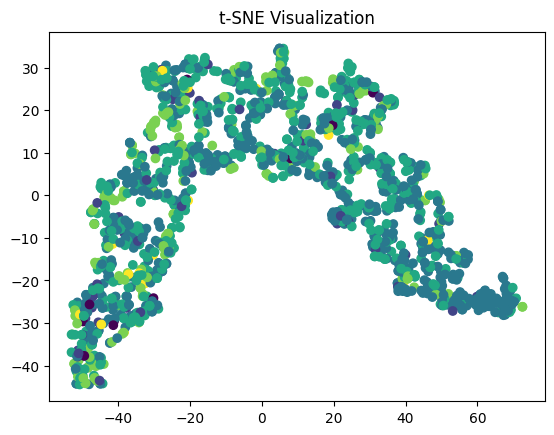

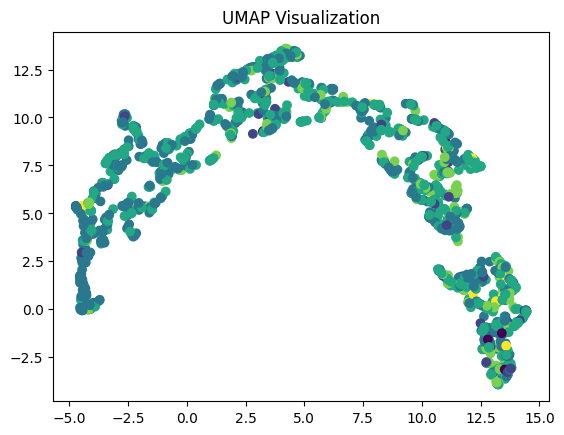

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.title('t-SNE Visualization')
plt.show()
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis')
plt.title('UMAP Visualization')
plt.show()